In [5]:
!pip install photutils

In [45]:
# # The standard fare:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from astropy.visualization import ZScaleInterval
# %matplotlib inline
# # Recall our use of this module to work with FITS files in Lab 4:
# from astropy.io import fits 


# # This lets us use various Unix (or Unix-like) commands within Python:
# import os 

# # We will see what this does shortly.
# import glob 
# import astropy.time

# import astropy.stats as stat
# from astropy.stats import mad_std
# from astropy.stats import sigma_clip
# from photutils.utils import calc_total_error

# from photutils import aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table, Column
from astropy.visualization import ZScaleInterval
import astropy.time
import pandas as pd
import glob 
import scipy.signal
import scipy.ndimage.interpolation as interp
import shutil
import pdb
import photutils
import astropy.stats as stat
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from photutils.utils import calc_total_error
import os

from photutils import aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder

In [10]:
#changing directory into where shift_methods is
os.chdir('C:/Users/amh77/Desktop/Documents/reducing 5 nights of data')

In [11]:
import shift_methods as p
from importlib import reload
%reload_ext autoreload 
%autoreload 2 
reload(p)

<module 'shift_methods' from 'C:\\Users\\amh77\\Desktop\\Documents\\reducing 5 nights of data\\shift_methods.py'>

In [12]:
def filesorter(filename, foldername, fitskeyword_to_check, keyword):
    '''
    Takes .fit files with a specific keyword value in their header and sends them to the specified
    folder-- if the folder does't exist, it creates it.
    
    Inputs:
    filename (str) - name of .fits file
    foldername (str) - name of folder that the .fits file may be sorted to
    fitskeyword_to_check (str) - if the value of the header category keyword matches this input, then the .fits file will 
                                    be sorted to foldername
    keyword (str) - the header category that is being checked
    '''
    # Checking to see if the filename exists, if it doesn't, it prints that the filename does not exist or that it has been moved.  
    if os.path.exists(filename):
        pass
    else:
        print(filename + " does not exist or has already been moved.")
        return
    #acquiring all 'column' headers for specified filename, assigning it to header
    #then assigning values under specified header keyword to fits_type
    header = fits.getheader(filename)
    fits_type = header[keyword]
    
    # Checking to see if foldername exists. If it does, move on, if it doesn't, it generates a folder of that name.
    if os.path.exists(foldername):
        pass
    else:
        print("Making new directory: " + foldername)
        os.mkdir(foldername)
    
    # Checks to see if the fits_type we got from the keyword header matches the fitskeyword we are looking for. If it does, it moves it into the destination which is specified by the
    # foldername we inputted into the function. If it does not, it just doesn't do anything. 
    if fits_type == fitskeyword_to_check:
        destination = foldername + '/'
        print("Moving " + filename + " to: ./" + destination + filename)
        os.rename(filename, destination + filename)  
    return

In [13]:
def sortall(master_directory):
    '''
    Loops through each directory in a given master directory for darks and flats, sorts them based on EXPTIME and FILTER.
    Inputs:
    master_directory (str) - the directory where all of the raw data folders are
    '''
    for root, dirs, files in os.walk(master_directory):
        for i in dirs:
            if 'Darks' in i:
                os.chdir(master_directory+"/"+i)
                dark_fits = glob.glob('*.fit')
                times = []
                for i in dark_fits:
                    headers = fits.getheader(i)
                    times.append(headers['EXPTIME'])
                times = np.array(times)
                uniquetimes = np.unique(times)
                for i in range(len(uniquetimes)):
                    for yeet in dark_fits:
                        filesorter(yeet, str(uniquetimes[i]) + 'sec', uniquetimes[i], 'EXPTIME')
            elif 'Flats' in i:
                os.chdir(master_directory+"/"+i)
                all_fits = glob.glob('*.fit')
                for filename in all_fits:
                    filesorter(filename, 'Blue', 'B', 'FILTER')
                    filesorter(filename, 'Visual', 'V', 'FILTER')
                    filesorter(filename, 'Red', 'R', 'FILTER')  
    return

In [14]:
master_dir = 'C:/Users/amh77/Desktop/Documents/Reducing 5 nights of data'
# sortall(master_dir)

In [15]:
def mediancombinenan(filelist):
    '''
    The function takes 1 input, a list of fits files to be combined, and takes the median
    pixel values for each pixel, outputting a median fits file. This function ignores naN values.
    
    Inputs:
    filelist (array-like) - a list of strings that are filepaths to images to be combined
    '''
    # Defines variable holding the length of the inputted list of files.
    n = len(filelist)
    
    # Assigns a name to the array data of the first file in the list.
    first_frame_data = fits.getdata(filelist[0])
    
        # Puts the y and x dimensions of the image into variables.
    imsize_y, imsize_x = first_frame_data.shape
    
    # Creates an empty three-dimensional array which will store the data from the entire list of files.
    fits_stack = np.zeros((imsize_y, imsize_x , n)) 
    
    # Goes through the list of files and sets the corresponding element in the array to the value of the
    # current pixel.
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        hed = fits.getheader(filelist[ii])
        if (hed['EXPTIME']> 60):
            im_normal = im/hed['EXPTIME']
            im_final = im_normal*60
        else: im_final = im
        fits_stack[:,:,ii] = im_final
        
    # Uses a numpy function to create a median frame along the third axis, which it then returns.        
    med_frame = np.nanmedian(fits_stack, axis = 2)
    
    return med_frame

def mediancombinescience(filelist):
    '''
    The function takes 1 input, a list of fits files to be combined, and takes the median
    pixel values for each pixel, outputting a median fits file.
    
    Inputs:
    filelist (array-like) - a list of strings that are filepaths to images to be combined
    '''
    # Defines variable holding the length of the inputted list of files.
    n = len(filelist)
    
    # Assigns a name to the array data of the first file in the list.
    first_frame_data = fits.getdata(filelist[0])
    
    # Puts the y and x dimensions of the image into variables.
    imsize_y, imsize_x = first_frame_data.shape
    
    # Creates an empty three-dimensional array which will store the data from the entire list of files.
    fits_stack = np.zeros((imsize_y, imsize_x , n)) 
    
    # Goes through the list of files and sets the corresponding element in the array to the value of the
    # current pixel.
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        fits_stack[:,:,ii] = im
        
    # Uses a numpy function to create a median frame along the third axis, which it then returns.        
    med_frame = np.nanmedian(fits_stack, axis = 2)
    
    return med_frame

def bias_subtract(filename, path_to_bias):
    '''
    This function takes two inputs: name of a file and a file path to the master bias and subtracts the master bias from the data
    It creates a file with the prefix 'b_', the new data, the header, and overwrites any existing files with the same name
    
    Inputs:
    filename (str) - filepath to image that is to be bias subtracted
    path_to_bias (str) - filepath to master bias image
    '''
    #grab information from input filepaths
    data = fits.getdata(filename)
    header = fits.getheader(filename)
    mb = fits.getdata(path_to_bias)
    
    #bias subtraction
    subtracted = data - mb

    #save the file
    fits.writeto('b_' + filename, subtracted, header, overwrite=True)
    return 

def getmasterbias(biasdirectory):
    '''
    This function creates a master bias frame given the path to the bias frames.
    
    Inputs:
    biasdirectory (str) - filepath to the biasframes folder
    
    Outputs:
    master_bias_path (str) - filepath to the master bias image
    '''
    
    os.chdir(biasdirectory)
    biasfiles = glob.glob('*Bias*.fit')
    #median combine all bias frames, and save the master
    fits.writeto('Master_Bias.fit', mediancombinescience(biasfiles), fits.getheader(biasfiles[0]), overwrite=True)
    master_bias_path = os.getcwd() + '/Master_Bias.fit'
    return(master_bias_path)
    
def getmasterdark(master_bias_path, darkdirectory):
    '''
    This function creates a master dark frame given the path to the dark frames.
    
    Inputs:
    master_bias_path (str) - filepath to the master bias image
    darkdirectory (str) - filepath to the darks folder
    
    Outputs:
    master_darkpath (str) - filepath to the master dark image
    '''
    
    os.chdir(darkdirectory)
    darkfiles = glob.glob('*.fit')
    #first must bias subtract all darks
    for i in darkfiles:
        bias_subtract(i, master_bias_path)
    biassubtracteddarks = glob.glob('b_*.fit')
    #combine to create a master dark
    CBSD = mediancombinescience(biassubtracteddarks)
    #save master dark
    fits.writeto('Master_Dark.fit', CBSD, fits.getheader(biassubtracteddarks[0]), overwrite = True)
    master_darkpath = os.getcwd() + '/Master_Dark.fit'
    return(master_darkpath)

def dark_subtract(filename, path_to_dark):
    '''
    Takes an image file name and a path to the master dark frame,
    normalizes the dark current and scales it to the image exposure time,
    subtracts it, and writes the resulting file to the working directory.
    
    Inputs:
    filename (str) - filepath an image
    path_to_dark (str) - filepath to the master dark image
    '''
    # Your code goes here.
    
    fileframe = fits.getdata(filename)
    fileheader = fits.getheader(filename)
    darkframe = fits.getdata(path_to_dark)
    darkheader = fits.getheader(path_to_dark)
    if (darkheader['EXPTIME'] != fileheader['EXPTIME']):
        masterdarknormalized = darkframe/darkheader['EXPTIME']
        exposure = fileheader['EXPTIME']
        darktouse = masterdarknormalized*exposure
    else:
        darktouse = darkframe

    newfile = fileframe - darktouse

    prefix = 'd'
    
    fits.writeto(prefix + filename, newfile, fileheader, overwrite=True) # finish this code too to save the FITS. Make sure it has the correct header!
    return

            
def flatfield_correction(filepath, pathtomastervisualflatfield, pathtomasterblueflatfield, pathtomasterredflatfield):
    '''
    Applies a flatfield correction to a images within a folder
    
    Inputs:
    filepath (str) - filepath to folder
    pathtomastervisualflatfield (str) - filepath to master V flat
    pathtomasterblueflatfield (str) - filepath to master B flat
    pathtomasterredflatfield (str) - filepath to master R flat
    '''
    os.chdir(filepath)
    reducedfits = glob.glob('db_*.fit')
    #loop through images 
    for i in reducedfits:
        #check image filter
        header = fits.getheader(i)
        print(header['FILTER'])
        if header['FILTER'] == 'V':
            path_master_flatfield = pathtomastervisualflatfield
        elif header['FILTER'] == 'B':
            path_master_flatfield = pathtomasterblueflatfield
        elif header['FILTER'] == 'R':
            path_master_flatfield = pathtomasterredflatfield
        
        #do the flatfield correction
        flatdata = fits.getdata(path_master_flatfield)
        data = fits.getdata(i)
        if (np.median(flatdata)!=1):
            flatdata = (flatdata/np.median(flatdata))
        output = data/flatdata
        yeet = np.where(np.isnan(output))
        output[yeet] = 0
        #save the flat fielded image
        prefix = 'f'
        fits.writeto(prefix + i, output, header, overwrite=True)
    ff_corrected = glob.glob('fdb_*.fit')
    #sort the fully reduced images by filter
    for fitsfile in ff_corrected:
        filesorter(fitsfile, 'ReducedV', 'V', 'FILTER')
        filesorter(fitsfile, 'ReducedB', 'B', 'FILTER')
        filesorter(fitsfile, 'ReducedR', 'R', 'FILTER')        
    

def process_images(path_to_science, master_bias_path, master_dark_path, pathtomastervisualflatfield, pathtomasterblueflatfield, pathtomasterredflatfield):
    '''
    Performs bias, dark, and flat field corrections on all science images, then sorts them by FILTER.
    
    Inputs:
    path_to_science (str) - filepath to the lights folder
    master_bias_path (str) - filepath to master bias
    master_dark_path (str) - filepath to master dark
    pathtomastervisualflatfield (str) - filepath to master V flat
    pathtomasterblueflatfield (str) - filepath to master B flat
    pathtomasterredflatfield (str) - filepath to master R flat
    '''
    os.chdir(path_to_science)
    fitsz = glob.glob('*.fit')
    print(fitsz)
    for i in fitsz:
        bias_subtract(i, master_bias_path)
    biassubtracted = glob.glob('b_*.fit')
    for i in biassubtracted:
        dark_subtract(i, master_dark_path)
    flatfield_correction(path_to_science, pathtomastervisualflatfield,pathtomasterblueflatfield, pathtomasterredflatfield)


In [9]:
path_to_master_bias = getmasterbias(master_dir+'/Bias')

In [10]:
master_dark_path_60sec = getmasterdark(path_to_master_bias, 'C:/Users/amh77/Desktop/Documents/Reducing 5 nights of data/Darks/60.0sec')
master_dark_path_100sec = getmasterdark(path_to_master_bias, 'C:/Users/amh77/Desktop/Documents/Reducing 5 nights of data/Darks/100.0sec')
master_dark_path_40sec = getmasterdark(path_to_master_bias, 'C:/Users/amh77/Desktop/Documents/Reducing 5 nights of data/Darks/40.0sec')

In [11]:
path_to_master_B_flatfield = 'C:/Users/amh77/Desktop/Documents/Reducing 5 nights of data/Flats/Blue/Master_Flat B 1_B_2004x1336_Bin2x2_Temp-25C_ExpTime49s.fit'
path_to_master_R_flatfield = 'C:/Users/amh77/Desktop/Documents/Reducing 5 nights of data/Flats/Red/Master_Flat R 2_R_2004x1336_Bin2x2_Temp-25C_ExpTime17s.fit'
path_to_master_V_flatfield = 'C:/Users/amh77/Desktop/Documents/Reducing 5 nights of data/Flats/Visual/Master_Flat V 2_V_2004x1336_Bin2x2_Temp-25C_ExpTime20s.fit'

In [16]:
def process_images_large(master_directory, path_to_master_bia, master_dark_path_60se,path_to_master_V_flatfiel,path_to_master_B_flatfiel, path_to_master_R_flatfiel):
    '''
    Applies process_images function to each night of data inside master directory
    '''
    for root, dirs, files in os.walk(master_directory):
            for i in dirs:
                if '2021' in i:
                    science_path_1 = master_directory+"/"+i
                    process_images(science_path_1, path_to_master_bia, master_dark_path_60se,path_to_master_V_flatfiel,path_to_master_B_flatfiel, path_to_master_R_flatfiel  )

In [13]:
process_images_large(master_dir, path_to_master_bias, master_dark_path_60sec,path_to_master_V_flatfield,path_to_master_B_flatfield, path_to_master_R_flatfield  )

['raw-T11-smithcollege-NGC2264-20210222-193532-B-BIN2-E-100-001.fit', 'raw-T11-smithcollege-NGC2264-20210222-193810-B-BIN2-E-100-002.fit', 'raw-T11-smithcollege-NGC2264-20210222-194019-B-BIN2-E-100-003.fit', 'raw-T11-smithcollege-NGC2264-20210222-194231-B-BIN2-E-100-004.fit', 'raw-T11-smithcollege-NGC2264-20210222-194441-B-BIN2-E-100-005.fit', 'raw-T11-smithcollege-NGC2264-20210222-194650-B-BIN2-E-100-006.fit', 'raw-T11-smithcollege-NGC2264-20210222-194901-V-BIN2-E-060-001.fit', 'raw-T11-smithcollege-NGC2264-20210222-195042-V-BIN2-E-060-002.fit', 'raw-T11-smithcollege-NGC2264-20210222-195206-V-BIN2-E-060-003.fit', 'raw-T11-smithcollege-NGC2264-20210222-195337-V-BIN2-E-060-004.fit', 'raw-T11-smithcollege-NGC2264-20210222-195501-V-BIN2-E-060-005.fit', 'raw-T11-smithcollege-NGC2264-20210222-195626-V-BIN2-E-060-006.fit', 'raw-T11-smithcollege-NGC2264-20210222-195753-R-BIN2-E-040-001.fit', 'raw-T11-smithcollege-NGC2264-20210222-195906-R-BIN2-E-040-002.fit', 'raw-T11-smithcollege-NGC2264-202

Moving fdb_raw-T11-smithcollege-NGC2264-20210222-205740-R-BIN2-W-040-002.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210222-205740-R-BIN2-W-040-002.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210222-205846-R-BIN2-W-040-003.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210222-205846-R-BIN2-W-040-003.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210222-205953-R-BIN2-W-040-004.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210222-205953-R-BIN2-W-040-004.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210222-210055-R-BIN2-W-040-005.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210222-210055-R-BIN2-W-040-005.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210222-210159-R-BIN2-W-040-006.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210222-210159-R-BIN2-W-040-006.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210222-210304-B-BIN2-W-100-001.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210222-210304-B-BIN2-W-100-001.fit
fdb_raw-T11-smithcollege-NGC

Moving fdb_raw-T11-smithcollege-NGC2264-20210222-221359-B-BIN2-W-100-005.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210222-221359-B-BIN2-W-100-005.fit
fdb_raw-T11-smithcollege-NGC2264-20210222-221359-B-BIN2-W-100-005.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210222-221609-B-BIN2-W-100-006.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210222-221609-B-BIN2-W-100-006.fit
fdb_raw-T11-smithcollege-NGC2264-20210222-221609-B-BIN2-W-100-006.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210222-221819-V-BIN2-W-060-001.fit to: ./ReducedV/fdb_raw-T11-smithcollege-NGC2264-20210222-221819-V-BIN2-W-060-001.fit
fdb_raw-T11-smithcollege-NGC2264-20210222-221819-V-BIN2-W-060-001.fit does not exist or has already been moved.
fdb_raw-T11-smithcollege-NGC2264-20210222-221819-V-BIN2-W-060-001.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210222-221956-V-BIN2-W-0

B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-193139-B-BIN2-E-100-001.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210226-193139-B-BIN2-E-100-001.fit
fdb_raw-T11-smithcollege-NGC2264-20210226-193139-B-BIN2-E-100-001.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-193409-B-BIN2-E-100-002.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210226-193409-B-BIN2-E-100-002.fit
fdb_raw-T11-smithcollege-NGC2264-20210226-193409-B-BIN2-E-100-002.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-193625-B-BIN2-E-100-003.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210226-193625-B-BIN2-E-100-003.fit
fdb_raw-T11-

Moving fdb_raw-T11-smithcollege-NGC2264-20210226-203001-R-BIN2-W-040-001.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210226-203001-R-BIN2-W-040-001.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-203116-R-BIN2-W-040-002.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210226-203116-R-BIN2-W-040-002.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-203221-R-BIN2-W-040-003.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210226-203221-R-BIN2-W-040-003.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-203328-R-BIN2-W-040-004.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210226-203328-R-BIN2-W-040-004.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-203435-R-BIN2-W-040-005.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210226-203435-R-BIN2-W-040-005.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-203543-R-BIN2-W-040-006.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210226-203543-R-BIN2-W-040-006.fit
Moving fdb_raw-T11-smithcoll

Moving fdb_raw-T11-smithcollege-NGC2264-20210226-223019-V-BIN2-W-060-003.fit to: ./ReducedV/fdb_raw-T11-smithcollege-NGC2264-20210226-223019-V-BIN2-W-060-003.fit
fdb_raw-T11-smithcollege-NGC2264-20210226-223019-V-BIN2-W-060-003.fit does not exist or has already been moved.
fdb_raw-T11-smithcollege-NGC2264-20210226-223019-V-BIN2-W-060-003.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-223151-V-BIN2-W-060-004.fit to: ./ReducedV/fdb_raw-T11-smithcollege-NGC2264-20210226-223151-V-BIN2-W-060-004.fit
fdb_raw-T11-smithcollege-NGC2264-20210226-223151-V-BIN2-W-060-004.fit does not exist or has already been moved.
fdb_raw-T11-smithcollege-NGC2264-20210226-223151-V-BIN2-W-060-004.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210226-223320-V-BIN2-W-060-005.fit to: ./ReducedV/fdb_raw-T11-smithcollege-NGC2264-20210226-223320-V-BIN2-W-060-005.fit
fdb_raw-T11-smithcollege-NGC2264-20210226-223320-V-BIN2-W-060-005.

R
R
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdb_raw-T11-smithcollege-NGC2264-20210301-203128-B-BIN2-W-100-001.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210301-203128-B-BIN2-W-100-001.fit
fdb_raw-T11-smithcollege-NGC2264-20210301-203128-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210301-203359-B-BIN2-W-100-002.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210301-203359-B-BIN2-W-100-002.fit
fdb_raw-T11-smithcollege-NGC2264-20210301-203359-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210301-203607-B-BIN2-W-100-003.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210301-203607-B-BIN2-W-100-003.fit
fdb_raw-T11-smithcollege-NGC2264-20210301-203607-B-BIN2-W-100-003.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210301-203817-B-BIN2-W-100-004.fit to: ./ReducedB/fdb_raw-T11-smithcol

Moving fdb_raw-T11-smithcollege-NGC2264-20210301-215449-R-BIN2-W-040-006.fit to: ./ReducedR/fdb_raw-T11-smithcollege-NGC2264-20210301-215449-R-BIN2-W-040-006.fit
Moving fdb_raw-T11-smithcollege-NGC2264-20210301-215552-B-BIN2-W-100-001.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210301-215552-B-BIN2-W-100-001.fit
fdb_raw-T11-smithcollege-NGC2264-20210301-215552-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210301-215819-B-BIN2-W-100-002.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210301-215819-B-BIN2-W-100-002.fit
fdb_raw-T11-smithcollege-NGC2264-20210301-215819-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210301-220028-B-BIN2-W-100-003.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210301-220028-B-BIN2-W-100-003.fit
fdb_raw-T11-smithcollege-NGC2264-20210301-220028-B-BIN2-W-100-003.fit does not exist or has already been moved.
Moving fdb_raw-T

B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdb_raw-T11-smithcollege-NGC2264-20210302-223235-B-BIN2-W-100-001.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210302-223235-B-BIN2-W-100-001.fit
fdb_raw-T11-smithcollege-NGC2264-20210302-223235-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210302-223507-B-BIN2-W-100-002.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210302-223507-B-BIN2-W-100-002.fit
fdb_raw-T11-smithcollege-NGC2264-20210302-223507-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210302-223719-B-BIN2-W-100-003.fit to: ./ReducedB/fdb_raw-T11-smithcollege-NGC2264-20210302-223719-B-BIN2-W-100-003.fit
fdb_raw-T11-smithcollege-NGC2264-20210302-223719-B-BIN2-W-100-003.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-NGC2264-20210302-223930-B-BIN2-W-100-004.fit to: ./R

fdb_raw-T11-smithcollege-Cone Nebula-20210307-192428-V-BIN2-E-060-003.fit does not exist or has already been moved.
fdb_raw-T11-smithcollege-Cone Nebula-20210307-192428-V-BIN2-E-060-003.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-Cone Nebula-20210307-192559-V-BIN2-E-060-004.fit to: ./ReducedV/fdb_raw-T11-smithcollege-Cone Nebula-20210307-192559-V-BIN2-E-060-004.fit
fdb_raw-T11-smithcollege-Cone Nebula-20210307-192559-V-BIN2-E-060-004.fit does not exist or has already been moved.
fdb_raw-T11-smithcollege-Cone Nebula-20210307-192559-V-BIN2-E-060-004.fit does not exist or has already been moved.
Moving fdb_raw-T11-smithcollege-Cone Nebula-20210307-192731-V-BIN2-E-060-005.fit to: ./ReducedV/fdb_raw-T11-smithcollege-Cone Nebula-20210307-192731-V-BIN2-E-060-005.fit
fdb_raw-T11-smithcollege-Cone Nebula-20210307-192731-V-BIN2-E-060-005.fit does not exist or has already been moved.
fdb_raw-T11-smithcollege-Cone Nebula-20210307-192731-V-BIN2-E-060-005.fit does n

In [28]:
def alignandcombineBband(master_directory):
    '''
    Aligns and Combines each night of science data in the B-band to create master images for each of them. 
    '''
    for root, dirs, files in os.walk(master_directory):
            for i in dirs:
                if '2021' in i:
                    print(i)
                    yuhhh = str(i)
                    print(yuhhh)
                    science_path_B = master_dir +"/"+i+"/ReducedB"
                    os.chdir(science_path_B)
                    lightslist = glob.glob('fdb_*.fit')
                    xshift = []
                    yshift = []
                    for i in lightslist:
                        reference_image = lightslist[0]
                        if 'BIN2-W' in reference_image:
                            initial_state = 'BIN2-W'
                        elif 'BIN2-E' in reference_image:
                            initial_state = 'BIN2-E'
                        if initial_state in i:
                            x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(i), 1000, 500, 800)
                            xshift.append(x_temp)
                            yshift.append(y_temp)
                        else:
                            flipped = fits.getdata(i)[::-1,::-1]
                            x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
                            xshift.append(x_temp)
                            yshift.append(y_temp)
                    reference_image = lightslist[0]
                    for i in np.arange(len(lightslist)):
                        if 'BIN2-W' in reference_image:
                            initial_state = 'BIN2-W'
                        elif 'BIN2-E' in reference_image:
                            initial_state = 'BIN2-E'
                        if initial_state in lightslist[i]:
                            header = fits.getheader(lightslist[i])
                            fits.writeto('shifted' + lightslist[i], p.shift_image(fits.getdata(lightslist[i]), xshift[i], yshift[i]), header, overwrite=True)
                        else:
                            header = fits.getheader(lightslist[i])
                            fits.writeto('shifted' + lightslist[i], p.shift_image(fits.getdata(lightslist[i])[::-1,::-1], xshift[i], yshift[i]), header, overwrite=True)
                    shiftedlist = glob.glob('shifted*.fit')
                    fits.writeto(initial_state+ yuhhh +'MasterScience_B.fit ', mediancombinescience(shiftedlist), header, overwrite=True)


In [29]:
alignandcombineBband(master_dir)

20210222
20210222
20210226
20210226
20210301
20210301
20210302
20210302
20210307
20210307


In [30]:
from pathlib import Path

In [31]:
for root, dirs, files in os.walk(master_dir):
            for i in dirs:
                if '2021' in i:
                    science_path_B = master_dir +"/"+i+"/ReducedB"
                    os.chdir(science_path_B)
                    current_master = glob.glob('*Master*.fit')
                    Path(science_path_B + '/' + current_master[0]).rename(master_dir + '/Master Blue/'+current_master[0])

In [43]:
os.chdir(master_dir + '/Master Blue')

In [44]:
masterlist = glob.glob('*.fit')
initial_state = 'BIN2-E'
reference_im_dat = fits.getdata(master_dir + '/Master Blue/BIN2-E20210222MasterScience_B.fit')
for i in masterlist:
    if initial_state in i:
        x_temp, y_temp = p.cross_image(reference_im_dat, fits.getdata(i), 1002, 668, 1000)
        header = fits.getheader(i)
        fits.writeto('shifted_' + i, p.shift_image(fits.getdata(i),x_temp,y_temp),header, overwrite = True)
    else:
        x_temp, y_temp = p.cross_image(reference_im_dat, fits.getdata(i)[::-1,::-1], 1002, 668, 1000)
        header = fits.getheader(i)
        fits.writeto('shifted_' + i, p.shift_image(fits.getdata(i)[::-1,::-1], x_temp, y_temp), header, overwrite = True)

        

In [46]:
shifted_masterlist = glob.glob('shifted_*.fit')

In [49]:
def measurePhotometry(fitsfile, star_xpos, star_ypos, aperture_radius, sky_inner, sky_outer, error_array):
    """
    This function takes a fitsfile, positions of stars, an aperture radius, annuli specifications, and an error image
    and outputs a photometry table for the image.
    """
    image = fits.getdata(fitsfile)
    mn, mx = ZScaleInterval().get_limits(image)#helps to get good size for a figure
    #Creates the aperture (around the stars) and the annulus (a shell around the aperture, for bkg calcs)
    #Makes a list of apertures and annuli for each star
    #starapertures = CircularAperture((star_xpos, star_ypos),r = aperture_radius)
    pos = [(star_xpos[i],star_ypos[i]) for i in np.arange(len(star_xpos))]
    starapertures = CircularAperture(pos,r = aperture_radius)
    skyannuli = CircularAnnulus(pos, r_in = sky_inner, r_out = sky_outer)
    phot_apers = [starapertures, skyannuli]
    plt.imshow(image, vmin = mn, vmax = mx)# added variables at end related to automatic scaling and zscaleinterval
    aperture.plot(color='w', lw=1.5, alpha=0.8)
    # Last time, we didn't have an error array to pass to the function. This time, our calculations will be more accurate because they consider  median background AND noise 
    phot_table = aperture_photometry(image, phot_apers, error=error_array) 
    # Calculate mean background in annulus and subtract from aperture flux
    bkg_mean = phot_table['aperture_sum_1'] / skyannuli.area
    bkg_starap_sum = bkg_mean * starapertures.area
    final_sum = phot_table['aperture_sum_0']-bkg_starap_sum
    phot_table['bg_subtracted_star_counts'] = final_sum
    # Calculating the mean error in the background. First, the error in the sum of values within the aperture
    #is divided by the area of the annulus to compute the mean error from the background. Sum error is computed by multiplying this by the area of the apertures - this is the total flux error within the aperture
    bkg_mean_err = phot_table['aperture_sum_err_1'] / skyannuli.area
    bkg_sum_err = bkg_mean_err * starapertures.area
    # Propagating the error to find the total error: taking the square root of the sum of the squares of the Poisson noise and the background error calculated above
    phot_table['bg_sub_star_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2)) 
    return phot_table
def bg_error_estimate(fitsfile):
    """
    This function takes a .fits file as an input, gets the data from the file, masks data greater than 3
    standard deviations from the median, replaces the masked data with NaNs, and calculates the median of this 
    error. Then, it writes two files, a background error file and a total error file, the latter considering the
    gain of the observing device (and thus Poisson noise). It outputs the raw data of the error_image.
    """
    fitsdata = fits.getdata(fitsfile) #gets the data from a .fits file
    hdr = fits.getheader(fitsfile) #saves the header as hdr
    # What is happening in the next step? Read the docstring for sigma_clip.
    # Answer: takes the median of the data and iterates over the data, rejecting values that are more than
    #3 standard deviations (sigma=3) away from the median. Returns an array with the same shape, with the 
    #rejected data masked 
    filtered_data = sigma_clip(fitsdata, sigma=3.,copy=False)
    # Summarize the following steps:
    # Takes the masked array and fills all the maxed points with a specified value, in this case a NaN
    # the background error = the square root of the above result
    # takes every nan point in the above line's output and sets it to the median of the bakground error
    bkg_values_nan = filtered_data.filled(fill_value=np.nan)
    bkg_error = np.sqrt(bkg_values_nan)
    bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)
    print("Writing the background-only error image: ", fitsfile.split('.')[0]+"_bgerror.fit")
    fits.writeto(fitsfile.split('.')[0]+"_bgerror.fit", bkg_error, hdr, overwrite=True)
    effective_gain = 1.4 # electrons per ADU
    error_image = calc_total_error(fitsdata, bkg_error, effective_gain)  
    print("Writing the total error image: ", fitsfile.split('.')[0]+"_error.fit")
    fits.writeto(fitsfile.split('.')[0]+"_error.fit", error_image, hdr, overwrite=True)
    return error_image

In [50]:
#Load in the image
hdu = fits.open('C:/Users/amh77/Desktop/Documents/astrometry/new-image.fits')
w = WCS(hdu[0].header)

image = hdu[0].data

#Load in the target list
targ = ascii.read('C:/Users/amh77/Desktop/Documents/astrometry/asu.txt', data_start=3, delimiter=';')
targ['_RA'].name = 'RA'
targ['_DE'].name = 'Dec'

#Put RA/Dec into an array
sky = np.array([list(targ['RA']), list(targ['Dec'])]).T

In [51]:
#Transform the RA and Dec into pixel coordinates.
pos = np.array(w.wcs_world2pix(sky[:,0], sky[:,1], 0)).T
aperture = photutils.CircularAperture(pos, r=10)
pos_x = []
pos_y = []
for i in np.arange(len(pos)):
    pos_x.append(pos[i][0])
    pos_y.append(pos[i][1])

<ipython-input-52-957ce6e74da7>:5: RuntimeWarning: divide by zero encountered in log10
  mn, mx = ZScaleInterval().get_limits(np.log10(image))
<ipython-input-52-957ce6e74da7>:14: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(image), origin = 'lower', vmin = mn, vmax = mx)


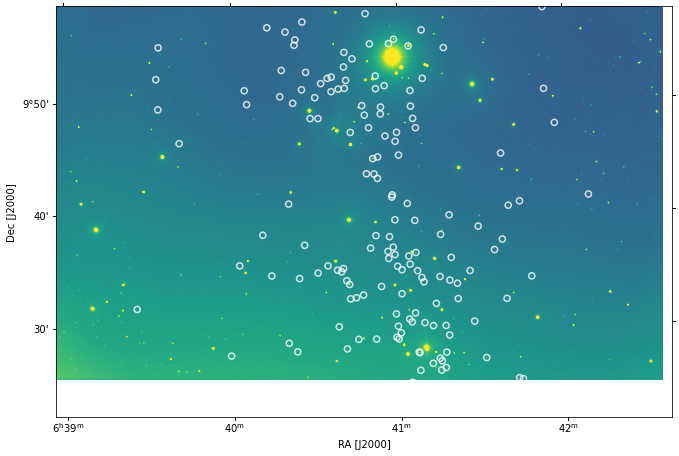

In [52]:
#Plot the apertures
%matplotlib inline

#Scale your image to something reasonble.
mn, mx = ZScaleInterval().get_limits(np.log10(image))

plt.figure(figsize = [10,7])

#Use the wcs solution to use sky coordinates when plotting. 
ax = plt.subplot(projection = w)
plt.subplots_adjust(right = 0.98, top = 0.98)

#Plot the apertures.
ax.imshow(np.log10(image), origin = 'lower', vmin = mn, vmax = mx)
aperture.plot(color='w', lw=1.5, alpha=0.8)

ax.set_xlabel('RA [J2000]')
ax.set_ylabel('Dec [J2000]')


Writing the background-only error image:  shifted_BIN2-E20210222MasterScience_B_bgerror.fit
Writing the total error image:  shifted_BIN2-E20210222MasterScience_B_error.fit
Writing the background-only error image:  shifted_BIN2-E20210226MasterScience_B_bgerror.fit
Writing the total error image:  shifted_BIN2-E20210226MasterScience_B_error.fit
Writing the background-only error image:  shifted_BIN2-E20210307MasterScience_B_bgerror.fit
Writing the total error image:  shifted_BIN2-E20210307MasterScience_B_error.fit


<ipython-input-49-726afd092deb>:65: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)


Writing the background-only error image:  shifted_BIN2-W20210301MasterScience_B_bgerror.fit
Writing the total error image:  shifted_BIN2-W20210301MasterScience_B_error.fit


<ipython-input-64-27b48934e15d>:7: RuntimeWarning: invalid value encountered in true_divide
  phot_table['SNR'] = phot_table['aper_sum_bkgsub']/phot_table['err']


Writing the background-only error image:  shifted_BIN2-W20210302MasterScience_B_bgerror.fit
Writing the total error image:  shifted_BIN2-W20210302MasterScience_B_error.fit


<ipython-input-64-27b48934e15d>:7: RuntimeWarning: invalid value encountered in true_divide
  phot_table['SNR'] = phot_table['aper_sum_bkgsub']/phot_table['err']


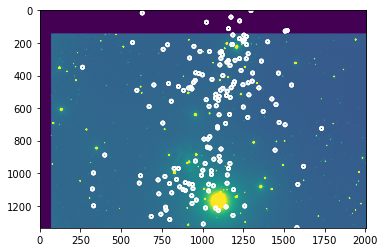

In [64]:
for i in shifted_masterlist:
    header = fits.getheader(i)
    error = bg_error_estimate(i)
    phot_table = measurePhotometry(i, pos_x, pos_y, 10, 12, 15, error)
    phot_table['bg_subtracted_star_counts'].name = 'aper_sum_bkgsub'
    phot_table['bg_sub_star_cts_err'].name = 'err'
    phot_table['SNR'] = phot_table['aper_sum_bkgsub']/phot_table['err']
    phot_table = phot_table[['id', 'xcenter', 'ycenter', 'aper_sum_bkgsub', 'err', 'SNR']]
    ascii.write(phot_table, i[14:-4] + '.dat', names = ['id', 'xcenter', 'ycenter', 'aper_sum_bkgsub', 'err', 'SNR'],overwrite=True)

In [75]:
import datetime as dt
from astropy.table import QTable
cwd = master_dir + '/Master Blue/'
dat = sorted(glob.glob('2021*.dat'))
file = []
num = []
name = []
filter_ = []
exp = []
date = []
start = []
phot_table_file = []
x = 1
print(dat)
for j,i in enumerate(dat):
    hdr = fits.getheader(shifted_masterlist[j])
    file.append(cwd+shifted_masterlist[j])
    num.append(x)
    name.append('NGC_2264')
    filter_.append(hdr['FILTER'])
    exp.append(hdr['EXPTIME'])
    date.append(dt.datetime.strptime(hdr['DATE-OBS'].replace('T', ' '), '%Y-%m-%d %H:%M:%S').strftime('%Y%m%d'))
    start.append(hdr['DATE-OBS'])
    phot_table_file.append(cwd+i)
    x+=1
t = QTable([file, num, name, filter_, exp, date, start, phot_table_file],
names=['file', 'num', 'name', 'filter', 'exp', 'date', 'start', 'phot_table_file'])
ascii.write(t,'phot_master_obslog.dat', names=['file', 'num', 'name', 'filter', 'exp','date', 'start', 'phot_table_file'],overwrite=True)

['20210222MasterScience_B.dat', '20210226MasterScience_B.dat', '20210301MasterScience_B.dat', '20210302MasterScience_B.dat', '20210307MasterScience_B.dat']
